# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [22]:
rect_start = None
rect_end = None
drawing = False

In [23]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [24]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [ ]:
coord = interactive_bbox_selection("frames/frame_0000.png")

### Segment image based on rectangle coordinates

In [ ]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [30]:
def segmenting_image(coordinates, model, source, device="cpu"):
    results = model(source,
                    device=device,
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

Coordinates: [647, 65, 3133, 3364]

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\backgroundFunctions\images\IMG_20250504_142304.jpg: 640x640 1 0, 3134.5ms
Speed: 79.9ms preprocess, 3134.5ms inference, 47.8ms postprocess per image at shape (1, 3, 640, 640)


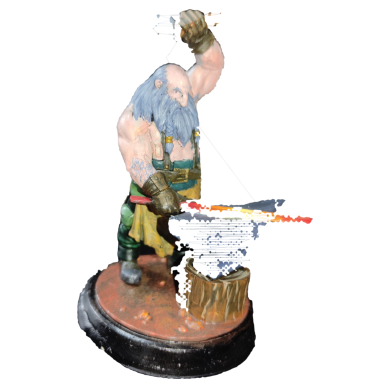

In [31]:
from ultralytics import SAM
%matplotlib inline
import torch

rect_start = None
rect_end = None
drawing = False

source = "images/IMG_20250504_142304.jpg"
model = SAM("models/sam2_l.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source, device)

## 3D reconstruction from videos

### DUSt3R

In [40]:
import torch
from dust3r.cloud_opt import GlobalAlignerMode, global_aligner
from dust3r.image_pairs import make_pairs
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images

def runDUSt3R(device: str = "cuda", dir_path: str = "images"):
    batch_size = 1
    schedule = "cosine"
    lr = 0.001
    niter = 1000
    model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)
    images = load_images(dir_path, size=512)
    pairs = make_pairs(images, scene_graph="complete", prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)
    scene = global_aligner(
        output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer
    )
    loss = scene.compute_global_alignment(
        init="mst", niter=niter, schedule=schedule, lr=lr
    )

    scene.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = "images"

runDUSt3R(device=device, dir_path=base_path)

In [39]:
import open3d as o3d

cloud_path = "reconstruction.ply"
pcd = o3d.io.read_point_cloud(cloud_path)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")

## Pre-painting - coloring sketch

### Converting image to sketch

In [ ]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

In [ ]:
print(text_color_dict)

### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)